#**IMPORT LIBRARY & DATA**

In [ ]:
import numpy as np                
import pandas as pd               
import matplotlib.pyplot as plt   
import seaborn as sns             
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore')

pd.set_option('float_format', '{:.2f}'.format)  # Show float data in two decimal number

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Final Project/bank_marketing_cleaned.csv')

In [ ]:
# GROUP 1: All basic information of a client
client = df.columns[0:8]

#GROUP 2: Related with the last contact of the current campaign
ccampaign = df.columns[8:13]

# GROUP 3: previous campaign attributes
pcampaign = df.columns[13:16]

# GROUP 4: Social and economic context attributes
context = df.columns[16:-1]

# GROUP 5: True label
conversion = df.columns[-1]

print(f'Basic client information:\n{client}\n')
print(f'Related with the last contact of the current campaign:\n{ccampaign}\n')
print(f'Previous campaign attributes:\n{pcampaign}\n')
print(f'Social and economic context attributes:\n{context}\n')
print(f'True label:\n{conversion}\n')

Basic client information:
Index(['age', 'age_group', 'job', 'marital', 'education', 'default', 'housing',
       'loan'],
      dtype='object')

Related with the last contact of the current campaign:
Index(['contact', 'month', 'day_of_week', 'duration', 'campaign'], dtype='object')

Previous campaign attributes:
Index(['pdays', 'previous', 'poutcome'], dtype='object')

Social and economic context attributes:
Index(['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed'],
      dtype='object')

True label:
y



# **DATA PREPARATION FOR TRAINING**

## DATA PREPARATION

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [ ]:
X = df[list(client)+list(pcampaign)+list(context)].drop(columns=['age_group','cons.conf.idx'])
y = df[conversion]

# X.age_group = X.age_group.astype(str)
X.education = X.education.astype(str)
# X.housing = X.housing.astype(str)
# X.loan = X.loan.astype(str)
# X.default = X.default.astype(str)
# X.education = X.education.astype('float')

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   pdays           41188 non-null  int64  
 8   previous        41188 non-null  int64  
 9   poutcome        41188 non-null  object 
 10  emp.var.rate    41188 non-null  float64
 11  cons.price.idx  41188 non-null  float64
 12  euribor3m       41188 non-null  float64
 13  nr.employed     41188 non-null  float64
dtypes: float64(4), int64(3), object(7)
memory usage: 4.4+ MB


In [ ]:
X.head()

,age,job,marital,education,default,housing,loan,pdays,previous,poutcome,emp.var.rate,cons.price.idx,euribor3m,nr.employed
0,56,housemaid,married,2,0,0,0,999,0,nonexistent,1.10,93.99,4.86,5191.00
1,57,services,married,5,unknown,0,0,999,0,nonexistent,1.10,93.99,4.86,5191.00
2,37,services,married,5,0,1,0,999,0,nonexistent,1.10,93.99,4.86,5191.00
3,40,admin.,married,3,0,0,0,999,0,nonexistent,1.10,93.99,4.86,5191.00
4,56,services,married,5,0,0,1,999,0,nonexistent,1.10,93.99,4.86,5191.00


In [ ]:
print(f'shape of X: {X.shape} \nshape of y: {y.shape}')

shape of X: (41188, 14) 
shape of y: (41188,)


In [ ]:
# https://datascience.stackexchange.com/questions/78194/is-it-possible-to-have-stratified-train-test-split-of-a-set-based-on-two-columns
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.1,
                                                    shuffle=True,
                                                    stratify=pd.concat([X["job"], y], axis=1),
                                                    random_state=42)

X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train,
                                                  test_size = 0.2,
                                                  shuffle=True,
                                                  stratify=pd.concat([X_train["job"], y_train], axis=1),
                                                  random_state=42)

In [ ]:
for d in [X_train, y_train, X_val, y_val, X_test, y_test]:
  print(d.shape)

(29655, 14)
(29655,)
(7414, 14)
(7414,)
(4119, 14)
(4119,)


In [ ]:
#@title Save Dataset

X_train.to_csv('X_train.csv', index=False)
!cp X_train.csv '/content/gdrive/MyDrive/Final Project'

X_val.to_csv('X_val.csv', index=False)
!cp X_val.csv '/content/gdrive/MyDrive/Final Project'

X_test.to_csv('X_test.csv', index=False)
!cp X_test.csv '/content/gdrive/MyDrive/Final Project'

y_train.to_csv('y_train.csv', index=False)
!cp y_train.csv '/content/gdrive/MyDrive/Final Project'

y_val.to_csv('y_val.csv', index=False)
!cp y_val.csv '/content/gdrive/MyDrive/Final Project'

y_test.to_csv('y_test.csv', index=False)
!cp X_test.csv '/content/gdrive/MyDrive/Final Project'

## PIPELINE PREPARATION

In [ ]:
num_features = list(X.select_dtypes('number').columns)
cat_features = list(X.select_dtypes('object').columns)

print(num_features)
print(cat_features)

['age', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'euribor3m', 'nr.employed']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome']


In [ ]:
# PIPELINE FOR NUMERICAL FEATURES
num_pipe = Pipeline(steps=
                    [
                      ('impute', SimpleImputer(strategy='mean')),
                      ('scale', MinMaxScaler())
                     ]
                    )

# PIPELINE FOR CATEGORICAL FEATURES
cat_pipe = Pipeline(steps=
                    [
                      ('impute', SimpleImputer(strategy ='constant')),
                      ('onehot' , OneHotEncoder(handle_unknown='ignore',sparse=False))
                     ]
                    )

In [ ]:
#@title Test to find error feature
for feature in num_features+cat_features:

  col_transform = ColumnTransformer(transformers=
                                    [
                                      ('cat_col', cat_pipe, [feature]),
                                      ('num_col', num_pipe, num_features)                                                
                                    ]
                                    )
  print(feature)
  col_transform.fit_transform(X)

In [ ]:
# COLUMN TRANSFORMATION
col_transform = ColumnTransformer(transformers=
                                    [
                                      ('num_col', num_pipe, num_features),
                                      ('cat_col', cat_pipe, cat_features)                                                
                                    ]
                                    )

  # DATAFRAME AFTER TRANSFORMATION
data = pd.DataFrame(col_transform.fit_transform(X))
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
0,0.48,1.00,0.00,0.94,0.70,0.96,0.86,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
1,0.49,1.00,0.00,0.94,0.70,0.96,0.86,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
2,0.25,1.00,0.00,0.94,0.70,0.96,0.86,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
3,0.28,1.00,0.00,0.94,0.70,0.96,0.86,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
4,0.48,1.00,0.00,0.94,0.70,0.96,0.86,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00


In [ ]:
# INPUT COLUMN'S NAME AFTER TRASFORMATION

# Define categorical column name
onehot_features = list(col_transform.named_transformers_['cat_col'].named_steps['onehot'].get_feature_names(cat_features))

# Combine categorical and numerical columns name
columns_name = num_features + onehot_features

# Put columns name to dataframe
data.columns = columns_name
data.head()

,age,pdays,previous,emp.var.rate,cons.price.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_1,education_2,education_3,education_4,education_5,education_6,education_7,default_0,default_1,default_unknown,housing_0,housing_1,housing_unknown,loan_0,loan_1,loan_unknown,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0.48,1.00,0.00,0.94,0.70,0.96,0.86,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
1,0.49,1.00,0.00,0.94,0.70,0.96,0.86,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
2,0.25,1.00,0.00,0.94,0.70,0.96,0.86,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
3,0.28,1.00,0.00,0.94,0.70,0.96,0.86,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
4,0.48,1.00,0.00,0.94,0.70,0.96,0.86,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00


# **TRAINING MODEL**

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Classifier Metrics 
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import fbeta_score, cohen_kappa_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [ ]:
X_train = col_transform.fit_transform(X_train)
X_val = col_transform.transform(X_val)

## PREPARATION FUNCTION

In [ ]:
def matrix_plot(matrix, font_size):
  conf_matrix_df = pd.DataFrame(matrix)

  conf_matrix_df.index.name = 'Actual'
  conf_matrix_df.columns.name = 'Predicted'
  target_names = ['No', 'Yes']

  plt.figure(figsize = (10,7))
  sns.set(font_scale=font_size/9)#for label size
  sns.heatmap(conf_matrix_df/np.sum(conf_matrix_df), cmap="Greens", annot=True,annot_kws={"size": font_size}, fmt='.2%', xticklabels=target_names, yticklabels=target_names)

In [ ]:
#define a function to perform a grid search on the LGBM model
def randSearch(rand_Params, model):
    """Perform grid search on LGBM"""
    
    # Create the grid
    kfold = StratifiedKFold(n_splits=5)
    scoring = {'AUC': 'roc_auc'}
    rand = RandomizedSearchCV(model, rand_Params,verbose=0,cv=kfold,scoring = scoring , n_jobs=-1, refit='AUC')

    # Run the grid
    rand.fit(X_train, y_train ,verbose=0, 
                eval_set=[(X_val, y_val)], 
                eval_metric= 'auc')

    # Print the best parameters found
    print(rand.best_params_)
    print(rand.best_score_)

In [ ]:
def proba_result(model, proba):
  y_pred = model.predict_proba(X_val)
  y_predict = (y_pred[:,1] >= proba).astype(int)

  # CLASSIFICATION REPORT
  print(classification_report(y_val, y_predict))

  # CONFUSION MATRIX PLOT
  matrix = confusion_matrix(y_val, y_predict)
  matrix_plot(matrix, 12)

  return np.diag(matrix)

In [ ]:
def proba_result_test(model, proba, X_test, y_test):
  X_test = col_transform.transform(X_test)
  y_pred = model.predict_proba(X_test)
  y_predict = (y_pred[:,1] >= proba).astype(int)

  # CLASSIFICATION REPORT
  print(classification_report(y_test, y_predict))

  # CONFUSION MATRIX PLOT
  matrix = confusion_matrix(y_test, y_predict)
  matrix_plot(matrix, 12)

  return np.diag(matrix)

## LOGISTIC REGRESSION

In [ ]:
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression() 
logmodel.fit(X_train,y_train)
logpred = logmodel.predict(X_val)

# Save logistic model cross validation score
LOGCV = (cross_val_score(logmodel, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      6580
           1       0.71      0.18      0.29       834

    accuracy                           0.90      7414
   macro avg       0.81      0.59      0.62      7414
weighted avg       0.88      0.90      0.87      7414



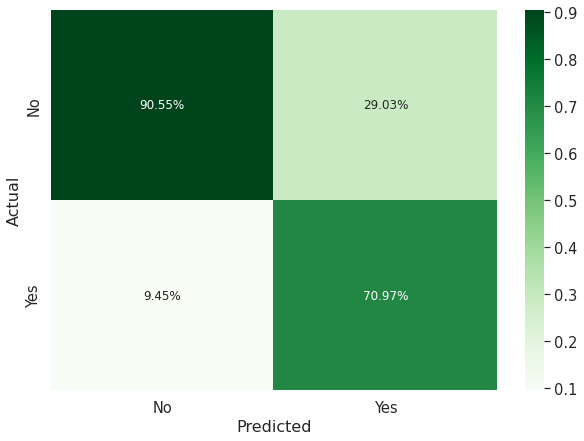

In [ ]:
# CLASSIFICATION REPORT
print(classification_report(y_val, logpred))

# CONFUSION MATRIX PLOT
matrix = confusion_matrix(y_val, logpred)
matrix_plot(matrix, 12)

logtrue_pos= np.diag(matrix)[1]

## KNN MODEL

In [ ]:
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier



k=1 84.44 (+/- 0.46)
k=2 88.71 (+/- 0.35)
k=3 88.06 (+/- 0.32)
k=4 89.20 (+/- 0.31)
k=5 89.00 (+/- 0.38)
k=6 89.44 (+/- 0.35)
k=7 89.28 (+/- 0.46)
k=8 89.39 (+/- 0.37)
k=9 89.30 (+/- 0.38)
k=10 89.50 (+/- 0.38)
k=11 89.37 (+/- 0.38)
k=12 89.57 (+/- 0.37)
k=13 89.51 (+/- 0.46)
k=14 89.57 (+/- 0.41)
k=15 89.51 (+/- 0.44)
k=16 89.61 (+/- 0.38)
k=17 89.56 (+/- 0.46)
k=18 89.60 (+/- 0.38)
k=19 89.58 (+/- 0.39)
k=20 89.66 (+/- 0.40)
k=21 89.63 (+/- 0.42)
k=22 89.66 (+/- 0.39)
k=23 89.59 (+/- 0.43)
k=24 89.65 (+/- 0.47)
k=25 89.60 (+/- 0.46)
The optimal number of neighbors is 19 with 89.7%


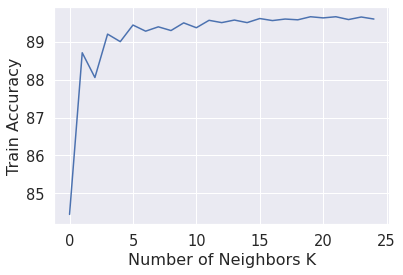

In [ ]:
# X_trainK, X_testK, y_trainK, y_testK = train_test_split(X, y, test_size = 0.2, 
#                                                         shuffle=True,
#                                                         stratify=pd.concat([X["age_group"], y], axis=1), 
#                                                         random_state = 42)

#Neighbors
neighbors = np.arange(0,25)

#Create empty list that will hold cv scores
cv_scores = []

#Perform 10-fold cross validation on training set for odd values of k:
for k in neighbors:
    k_value = k+1
    knn = KNeighborsClassifier(n_neighbors = k_value, weights='uniform', p=2, metric='euclidean')
    kfold = model_selection.KFold(n_splits=10, random_state=123)
    scores = model_selection.cross_val_score(knn, X_train, y_train, cv=kfold, scoring='accuracy')
    cv_scores.append(scores.mean()*100)
    print("k=%d %0.2f (+/- %0.2f)" % (k_value, scores.mean()*100, scores.std()*100))

optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print ("The optimal number of neighbors is %d with %0.1f%%" % (optimal_k, cv_scores[optimal_k]))

plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Train Accuracy')
plt.show()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)
knnpred = knn.predict(X_val)

KNNCV = (cross_val_score(knn, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      6580
           1       0.66      0.18      0.28       834

    accuracy                           0.90      7414
   macro avg       0.78      0.58      0.61      7414
weighted avg       0.88      0.90      0.87      7414



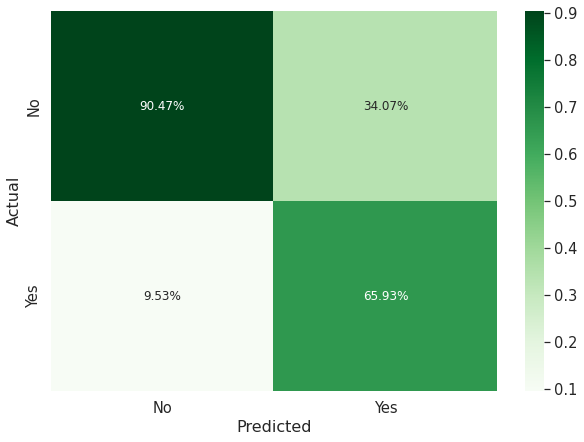

In [ ]:
# CLASSIFICATION REPORT
print(classification_report(y_val, knnpred))

# CONFUSION MATRIX PLOT
matrix = confusion_matrix(y_val, knnpred)
matrix_plot(matrix, 12)

knntrue_pos= np.diag(matrix)[1]

## RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 200)#criterion = entopy,gini
rfc.fit(X_train, y_train)
rfcpred = rfc.predict(X_val)

RFCCV = (cross_val_score(rfc, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      6580
           1       0.47      0.29      0.36       834

    accuracy                           0.88      7414
   macro avg       0.69      0.62      0.65      7414
weighted avg       0.86      0.88      0.87      7414



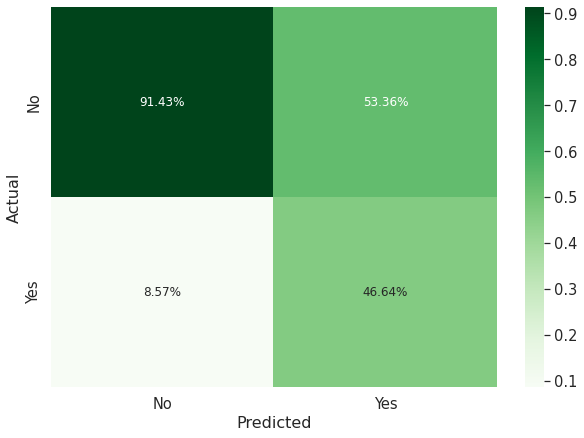

In [ ]:
# CLASSIFICATION REPORT
print(classification_report(y_val, rfcpred))

# CONFUSION MATRIX PLOT
matrix = confusion_matrix(y_val, rfcpred)
matrix_plot(matrix, 12)

rfctrue_pos= np.diag(matrix)[1]

##SVM MODEL

In [ ]:
from sklearn.svm import SVC
svc= SVC(kernel = 'sigmoid')
svc.fit(X_train, y_train)
svcpred = svc.predict(X_val)

SVCCV = (cross_val_score(svc, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      6580
           1       0.26      0.24      0.25       834

    accuracy                           0.84      7414
   macro avg       0.58      0.58      0.58      7414
weighted avg       0.83      0.84      0.83      7414



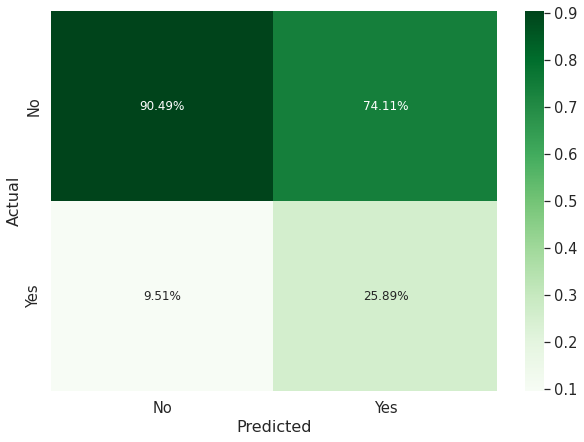

In [ ]:
# CLASSIFICATION REPORT
print(classification_report(y_val, svcpred))

# CONFUSION MATRIX PLOT
matrix = confusion_matrix(y_val, svcpred)
matrix_plot(matrix, 12)

svctrue_pos= np.diag(matrix)[1]

## XG BOOST

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgbprd = xgb.predict(X_val)

XGB = (cross_val_score(estimator = xgb, X = X_train, y = y_train, cv = 10).mean())

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      6580
           1       0.70      0.21      0.33       834

    accuracy                           0.90      7414
   macro avg       0.80      0.60      0.64      7414
weighted avg       0.88      0.90      0.88      7414



array([6503,  179])

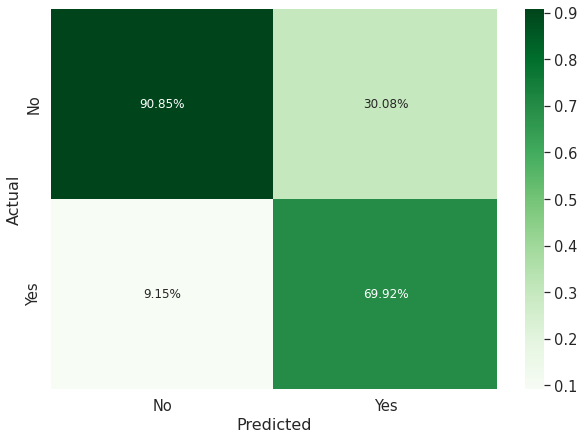

In [ ]:
# CLASSIFICATION REPORT
print(classification_report(y_val, xgbprd))

# CONFUSION MATRIX PLOT
matrix = confusion_matrix(y_val, xgbprd)
matrix_plot(matrix, 12)

xgbtrue_pos= np.diag(matrix)[1]
np.diag(matrix)

## GRADIENT BOOSTING

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbk = GradientBoostingClassifier()
gbk.fit(X_train, y_train)
gbkpred = gbk.predict(X_val)

GBKCV = (cross_val_score(gbk, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      6580
           1       0.69      0.22      0.33       834

    accuracy                           0.90      7414
   macro avg       0.80      0.60      0.64      7414
weighted avg       0.88      0.90      0.88      7414



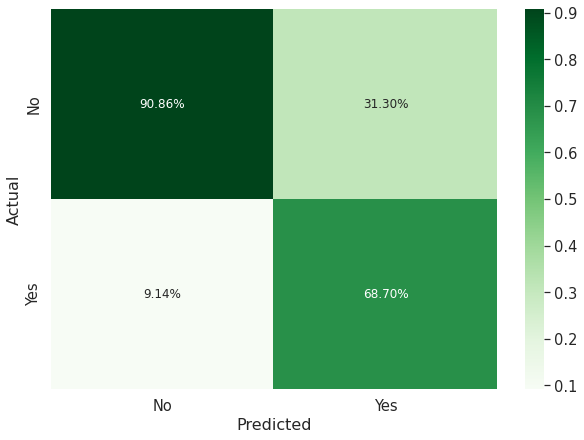

In [ ]:
# CLASSIFICATION REPORT
print(classification_report(y_val, gbkpred))

# CONFUSION MATRIX PLOT
matrix = confusion_matrix(y_val, gbkpred)
matrix_plot(matrix, 12)

gbktrue_pos = np.diag(matrix)[1]

## LIGHT GBM

In [ ]:
import lightgbm as lgb
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train, y_train)
lgbmpred = lgbm.predict(X_val)

LGBMCV = (cross_val_score(lgbm, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      6580
           1       0.66      0.23      0.34       834

    accuracy                           0.90      7414
   macro avg       0.79      0.61      0.64      7414
weighted avg       0.88      0.90      0.88      7414



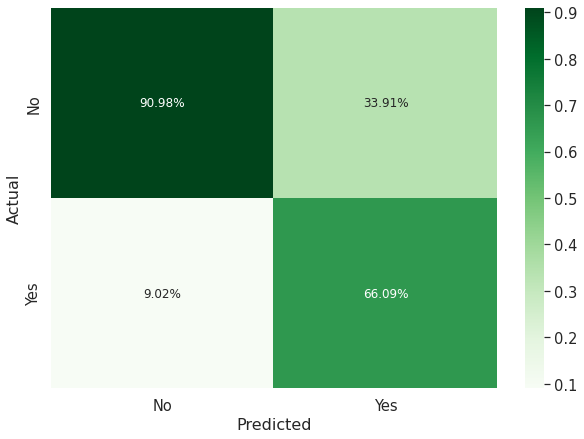

In [ ]:
# CLASSIFICATION REPORT
print(classification_report(y_val, lgbmpred))

# CONFUSION MATRIX PLOT
matrix = confusion_matrix(y_val, lgbmpred)
matrix_plot(matrix, 12)

lgbmtrue_pos= np.diag(matrix)[1]

## RESULTS

In [ ]:
models = pd.DataFrame({
                'Models': ['Logistic Model', 'K-Near Neighbors', 'Random Forest Classifier', 'Support Vector Machine',
                           'XGBoost', 'Gradient Boosting', 'LIGHT GBM'],
                'Score':  [LOGCV, KNNCV, RFCCV, SVCCV, XGB, GBKCV, LGBMCV],
                'TP_Count': [logtrue_pos, knntrue_pos, rfctrue_pos, svctrue_pos, xgbtrue_pos, gbktrue_pos, lgbmtrue_pos]})

models.sort_values(by='TP_Count', ascending=False)

,Models,Score,TP_Count
2,Random Forest Classifier,0.88,243
3,Support Vector Machine,0.83,204
6,LIGHT GBM,0.90,191
5,Gradient Boosting,0.90,180
4,XGBoost,0.90,179
0,Logistic Model,0.90,154
1,K-Near Neighbors,0.90,149


Accuracy is measured by the area under the ROC curve. An area of 1 represents a perfect test; an area of .5 represents a worthless test.

A rough guide for classifying the accuracy of a diagnostic test is the traditional academic point system:

.90-1 = excellent (A)

.80-.90 = good (B)

.70-.80 = fair (C)

.60-.70 = poor (D)

.50-.60 = fail (F)

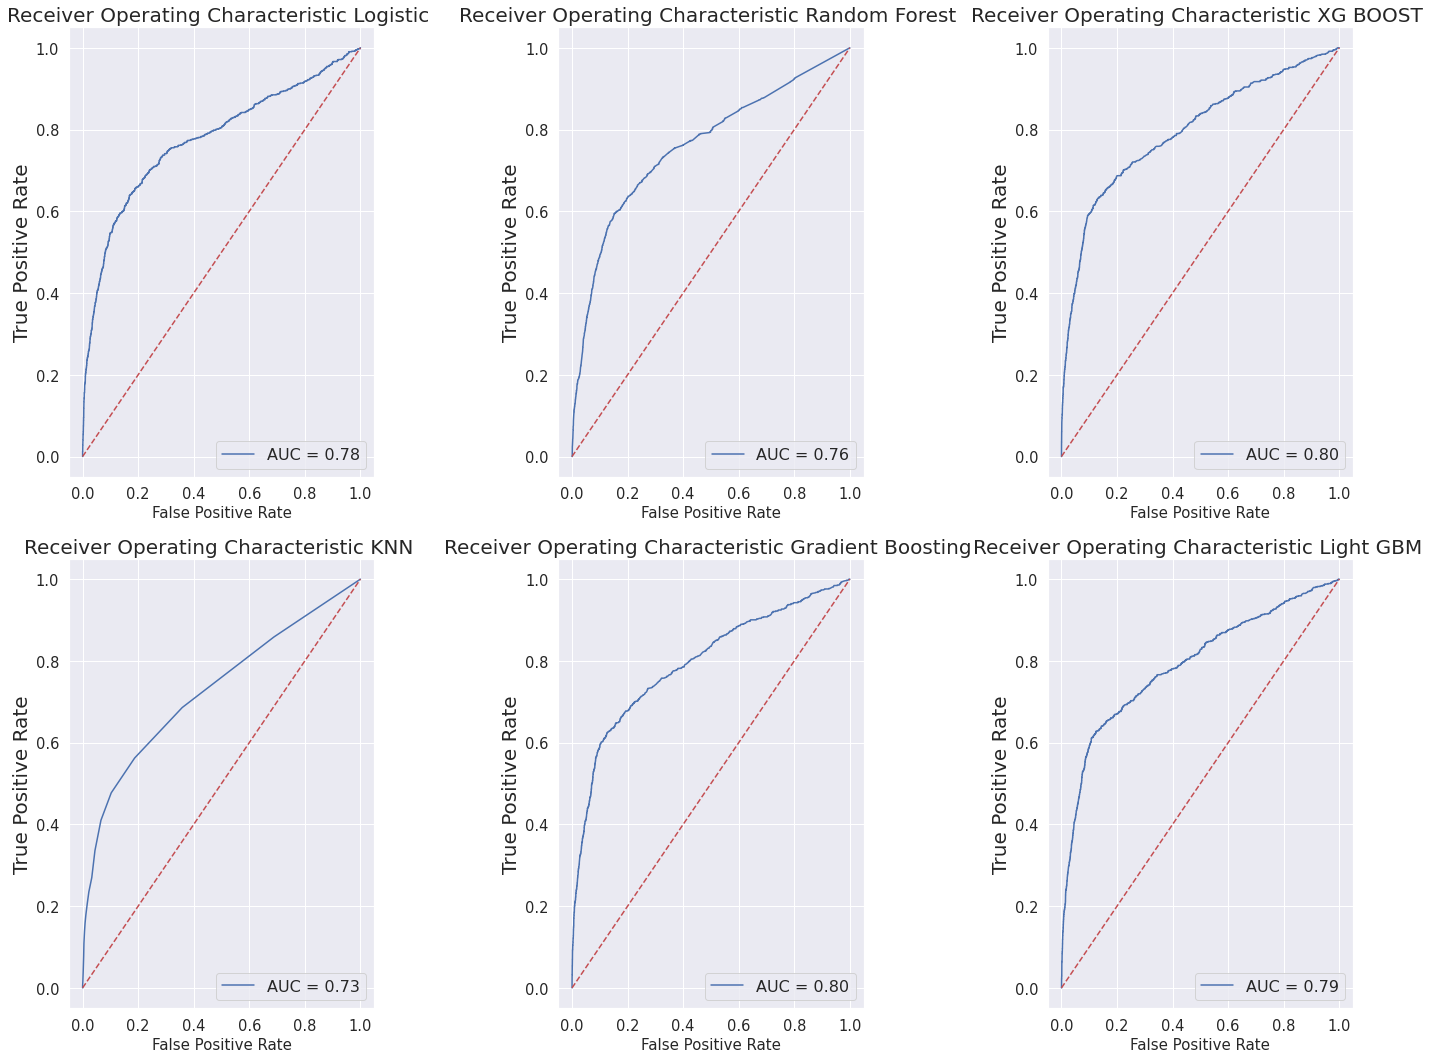

In [ ]:
fig, ax_arr = plt.subplots(nrows = 2, ncols = 3, figsize = (20,15))

# LOGISTIC
probs = logmodel.predict_proba(X_val)
preds = probs[:,1]
fprlog, tprlog, thresholdlog = metrics.roc_curve(y_val, preds)
roc_auclog = metrics.auc(fprlog, tprlog)

ax_arr[0,0].plot(fprlog, tprlog, 'b', label = 'AUC = %0.2f' % roc_auclog)
ax_arr[0,0].plot([0, 1], [0, 1],'r--')
ax_arr[0,0].set_title('Receiver Operating Characteristic Logistic ',fontsize=20)
ax_arr[0,0].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[0,0].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[0,0].legend(loc = 'lower right', prop={'size': 16})

# RANDOM FOREST 
probs = rfc.predict_proba(X_val)
preds = probs[:,1]
fprrfc, tprrfc, thresholdrfc = metrics.roc_curve(y_val, preds)
roc_aucrfc = metrics.auc(fprrfc, tprrfc)

ax_arr[0,1].plot(fprrfc, tprrfc, 'b', label = 'AUC = %0.2f' % roc_aucrfc)
ax_arr[0,1].plot([0, 1], [0, 1],'r--')
ax_arr[0,1].set_title('Receiver Operating Characteristic Random Forest ',fontsize=20)
ax_arr[0,1].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[0,1].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[0,1].legend(loc = 'lower right', prop={'size': 16})

# KNN
probs = knn.predict_proba(X_val)
preds = probs[:,1]
fprknn, tprknn, thresholdknn = metrics.roc_curve(y_val, preds)
roc_aucknn = metrics.auc(fprknn, tprknn)

ax_arr[1,0].plot(fprknn, tprknn, 'b', label = 'AUC = %0.2f' % roc_aucknn)
ax_arr[1,0].plot([0, 1], [0, 1],'r--')
ax_arr[1,0].set_title('Receiver Operating Characteristic KNN ',fontsize=20)
ax_arr[1,0].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[1,0].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[1,0].legend(loc = 'lower right', prop={'size': 16})

# XG BOOST
probs = xgb.predict_proba(X_val)
preds = probs[:,1]
fprxgb, tprxgb, thresholdxgb = metrics.roc_curve(y_val, preds)
roc_aucxgb = metrics.auc(fprxgb, tprxgb)

ax_arr[0,2].plot(fprxgb, tprxgb, 'b', label = 'AUC = %0.2f' % roc_aucxgb)
ax_arr[0,2].plot([0, 1], [0, 1],'r--')
ax_arr[0,2].set_title('Receiver Operating Characteristic XG BOOST ',fontsize=20)
ax_arr[0,2].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[0,2].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[0,2].legend(loc = 'lower right', prop={'size': 16})

# GRADIENT BOOSTING
probs = gbk.predict_proba(X_val)
preds = probs[:,1]
fprgbk, tprgbk, thresholdgbk = metrics.roc_curve(y_val, preds)
roc_aucgbk = metrics.auc(fprgbk, tprgbk)

ax_arr[1,1].plot(fprgbk, tprgbk, 'b', label = 'AUC = %0.2f' % roc_aucgbk)
ax_arr[1,1].plot([0, 1], [0, 1],'r--')
ax_arr[1,1].set_title('Receiver Operating Characteristic Gradient Boosting ',fontsize=20)
ax_arr[1,1].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[1,1].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[1,1].legend(loc = 'lower right', prop={'size': 16})

# LIGHT GBM
probs = lgbm.predict_proba(X_val)
preds = probs[:,1]
fprlgbm, tprlgbm, thresholdlgbm = metrics.roc_curve(y_val, preds)
roc_auclgbm = metrics.auc(fprlgbm, tprlgbm)

ax_arr[1,2].plot(fprlgbm, tprlgbm, 'b', label = 'AUC = %0.2f' % roc_auclgbm)
ax_arr[1,2].plot([0, 1], [0, 1],'r--')
ax_arr[1,2].set_title('Receiver Operating Characteristic Light GBM ',fontsize=20)
ax_arr[1,2].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[1,2].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[1,2].legend(loc = 'lower right', prop={'size': 16})


plt.subplots_adjust(wspace=0.2)
plt.tight_layout() 

# **BEST MODEL**

## TUNING

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV

In [ ]:
# Create parameters to search for num_leaves and max_depth
randParams = {
    'num_leaves': [15,25,35,45],
    'max_depth': [15,20,25,30]
    }

randSearch(randParams,xgb)

In [ ]:
# Create parameters to search for learning rate and estimators
randParams = {
    'learning_rate': [0.01, 0.03, 0.04],
    'n_estimators': np.arange(50,101,10).tolist(),
    'colsample_bytree': np.linspace(0.1,1,10).tolist(),
    'subsample': np.linspace(0.1,1,10).tolist(),
    'num_leaves': np.arange(5,25,5).tolist(),
    'max_depth': np.arange(5,25,5).tolist()
    }

randSearch(randParams,xgb)

{'subsample': 0.7000000000000001, 'num_leaves': 10, 'n_estimators': 80, 'max_depth': 10, 'learning_rate': 0.03, 'colsample_bytree': 0.6}
0.7977774939232758


In [ ]:
# Create parameters to search for learning rate and estimators
randParams = {
    'learning_rate': [0.01, 0.03, 0.04],
    'n_estimators': np.arange(50,201,10).tolist(),
    'colsample_bytree': np.linspace(0.1,1,10).tolist(),
    'subsample': np.linspace(0.1,1,10).tolist(),
    'num_leaves': np.arange(5,25,5).tolist(),
    'max_depth': np.arange(5,25,5).tolist()
    }

randSearch(randParams,lgbm)

{'subsample': 0.9, 'num_leaves': 20, 'n_estimators': 140, 'max_depth': 10, 'learning_rate': 0.03, 'colsample_bytree': 0.4}
0.7983268916221904


##XG BOOST

In [ ]:

final_model = XGBClassifier(
    n_estimators=10000,
    learning_rate=0.03,
    num_leaves=10,
    colsample_bytree=0.6,
    subsample=.7,
    max_depth=10,
    reg_alpha=0.041545473,
    reg_lambda=0.0735294,
    verbose=-1)

history = final_model.fit(X_train, y_train , 
                eval_set=[(X_train, y_train),(X_val, y_val)], 
                eval_metric='auc', verbose=50,early_stopping_rounds= 500)

[0]	validation_0-auc:0.813869	validation_1-auc:0.777193
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 500 rounds.
[50]	validation_0-auc:0.880256	validation_1-auc:0.789631
[100]	validation_0-auc:0.898254	validation_1-auc:0.788703
[150]	validation_0-auc:0.912851	validation_1-auc:0.787434
[200]	validation_0-auc:0.922978	validation_1-auc:0.784799
[250]	validation_0-auc:0.932386	validation_1-auc:0.78266
[300]	validation_0-auc:0.939936	validation_1-auc:0.780949
[350]	validation_0-auc:0.947222	validation_1-auc:0.778519
[400]	validation_0-auc:0.952672	validation_1-auc:0.776759
[450]	validation_0-auc:0.958607	validation_1-auc:0.774613
[500]	validation_0-auc:0.963365	validation_1-auc:0.772785
Stopping. Best iteration:
[2]	validation_0-auc:0.825863	validation_1-auc:0.792652



In [ ]:
best_iteration = final_model.get_booster().best_ntree_limit

y_pred = final_model.predict_proba(X_val, ntree_limit=best_iteration)
y_predict = (y_pred[:,1] >= 0.48).astype(int)

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      6580
           1       0.47      0.50      0.48       834

    accuracy                           0.88      7414
   macro avg       0.70      0.71      0.71      7414
weighted avg       0.88      0.88      0.88      7414



array([6109,  416])

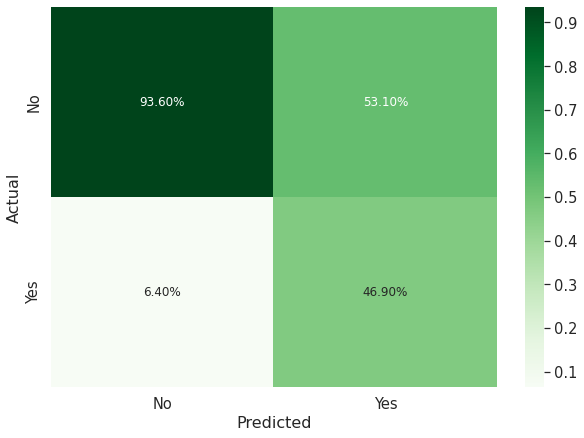

In [ ]:
# CLASSIFICATION REPORT
print(classification_report(y_val, y_predict))

# CONFUSION MATRIX PLOT
matrix = confusion_matrix(y_val, y_predict)
matrix_plot(matrix, 12)

np.diag(matrix)

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      3655
           1       0.44      0.50      0.47       464

    accuracy                           0.87      4119
   macro avg       0.69      0.71      0.70      4119
weighted avg       0.88      0.87      0.88      4119



array([3361,  231])

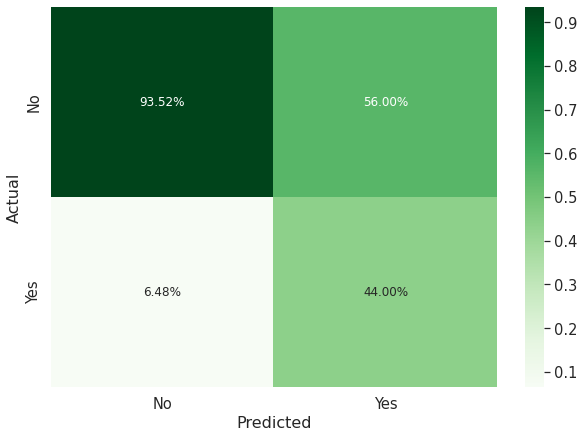

In [ ]:
proba_result_test(final_model, 0.48, X_test)

## LIGHT GBM

In [ ]:

light_model = lgb.LGBMClassifier(
    n_estimators=10000,
    learning_rate=0.03,
    num_leaves=20,
    colsample_bytree=0.4,
    subsample=.9,
    max_depth=10,
    reg_alpha=0.041545473,
    reg_lambda=0.0735294,
    verbose=-1)

history = light_model.fit(X_train, y_train , 
                eval_set=[(X_train, y_train),(X_val, y_val)], 
                eval_metric='auc', verbose=50,early_stopping_rounds= 500)

Training until validation scores don't improve for 500 rounds.
[50]	training's auc: 0.806498	training's binary_logloss: 0.276629	valid_1's auc: 0.795669	valid_1's binary_logloss: 0.278951
[100]	training's auc: 0.815866	training's binary_logloss: 0.267937	valid_1's auc: 0.79736	valid_1's binary_logloss: 0.272256
[150]	training's auc: 0.821964	training's binary_logloss: 0.26479	valid_1's auc: 0.797483	valid_1's binary_logloss: 0.271523
[200]	training's auc: 0.828079	training's binary_logloss: 0.26235	valid_1's auc: 0.797822	valid_1's binary_logloss: 0.271383
[250]	training's auc: 0.832948	training's binary_logloss: 0.260462	valid_1's auc: 0.798139	valid_1's binary_logloss: 0.271482
[300]	training's auc: 0.837171	training's binary_logloss: 0.258594	valid_1's auc: 0.797909	valid_1's binary_logloss: 0.271554
[350]	training's auc: 0.840223	training's binary_logloss: 0.256909	valid_1's auc: 0.79718	valid_1's binary_logloss: 0.271678
[400]	training's auc: 0.843505	training's binary_logloss: 0.

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       886
           1       0.61      0.47      0.53       114

    accuracy                           0.91      1000
   macro avg       0.77      0.72      0.74      1000
weighted avg       0.90      0.91      0.90      1000



array([852,  54])

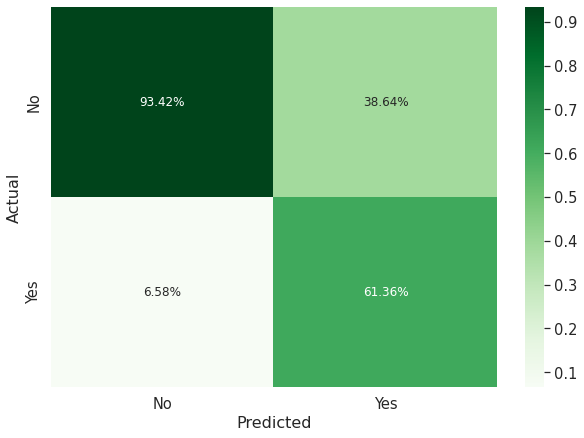

In [ ]:
test_X = X_test[:1000]
test_y = y_test[:1000]

proba_result_test(light_model, 0.35, test_X, test_y)

Recommended predicted dataset should be above 1000 samples for better prediction

- proba = 0.72: 80% < Precision(TP+FP) > 90%, 09% < Recall(TP+FN) < 13%
- proba = 0.60: 70% < Precision(TP+FP) < 76%, 13% < Recall(TP+FN) < 20%
- proba = 0.35: 55% < Precision(TP+FP) < 61%, 40% < Recall(TP+FN) < 50%

# **SAVE MODEL**

In [ ]:
# !mkdir '/content/gdrive/MyDrive/Final Project/saved_model' #create folder to save model

light_model.booster_.save_model('/content/gdrive/MyDrive/Final Project/saved_model/final_mode.txt')

In [ ]:
load_model = lgb.Booster(model_file='/content/gdrive/MyDrive/Final Project/saved_model/final_mode.txt')

In [ ]:
y_pred = load_model.predict(col_transform.transform(X_test), num_iteration=load_model.best_iteration)

# **TEST MODEL**

In [ ]:
import lightgbm as lgb
load_model = lgb.Booster(model_file='/content/gdrive/MyDrive/Final Project/saved_model/final_mode.txt')

input dataset
preprocess
load model
predict

In [ ]:
def upload_data():
  from google.colab import files
  uploaded = files.upload()
  keys = uploaded.keys()
  for each in keys:
      file_name = each
  data = pd.read_csv(file_name)
  return data

In [ ]:
def preprocess_data(data):
  from sklearn.pipeline import Pipeline
  from sklearn.impute import SimpleImputer
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.compose import ColumnTransformer
  from sklearn.preprocessing import OneHotEncoder

  num_features = list(data.select_dtypes('number').columns)
  cat_features = list(data.select_dtypes('object').columns)

  # PIPELINE FOR NUMERICAL FEATURES
  num_pipe = Pipeline(steps=
                      [
                        ('impute', SimpleImputer(strategy='mean')),
                        ('scale', MinMaxScaler())
                      ]
                      )

  # PIPELINE FOR CATEGORICAL FEATURES
  cat_pipe = Pipeline(steps=
                      [
                        ('impute', SimpleImputer(strategy ='constant')),
                        ('onehot' , OneHotEncoder(handle_unknown='ignore',sparse=False))
                      ]
                      )
                      
  # COLUMN TRANSFORMATION
  col_transform = ColumnTransformer(transformers=
                                      [
                                        ('num_col', num_pipe, num_features),
                                        ('cat_col', cat_pipe, cat_features)                                                
                                      ]
                                      )
  
  col_transform.transform(data)

  return data

In [ ]:
a =pd.read_csv('/content/X_test.csv')

In [ ]:
preprocess_data(a)

NotFittedError: ignored